## Mini Projeto - Classificador de dígitos MNIST
Curso: Ciência de dados e inteligência artificial  
Aluno: Vinícius Vieri Bezerra de Lima  
Disciplina: Aprendizado de máquina  
Professores: Bruno Jefferson e Gilberto Farias

Utilizando um dataset MINST adaptado, foi implementado um projeto de reconhecimento de dígitos à mão. O dataset está em escala de cinza com os dígitos 0, 1, 4 e 5. 

## Importando bibliotecas necessárias

In [82]:
import random
import numpy as np
from numpy import linalg as LA
from random import sample
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Modelos

### Perceptron

In [4]:
class PLA:
    def __init__(self, maxIter=30000):
        self.maxIter = maxIter
        self.w = None
        self.best_w = None
        self.best_accuracy = 0

    def get_w(self):
        return self.w  

    def listaPCI(self, X, y):
        resultados = np.dot(X, self.w)  
        resultados = np.sign(resultados)  
        indices_inc = np.where(resultados != y)[0]  
        return indices_inc

    def accuracy(self, X, y):
        prediction = np.dot(X, self.w)
        prediction = np.sign(prediction)
        accuracy = np.mean(prediction == y)
        return accuracy

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])  
        self.best_w = self.w.copy()  # Inicializa a melhor reta com a atual
        iterador = 0

        while iterador < self.maxIter:
            indices_inc = self.listaPCI(X, y)  

            if len(indices_inc) == 0:  
                break

            i = random.choice(indices_inc)
            self.w = self.w + y[i] * X[i]
            iterador += 1

            # Calcula a acurácia com a reta atual e atualiza a melhor reta se necessário
            current_accuracy = self.accuracy(X, y)
            if current_accuracy > self.best_accuracy:
                self.best_w = self.w.copy()
                self.best_accuracy = current_accuracy

        print("Número total de iterações realizadas: ", iterador) 
        self.w = self.best_w  # Retorna a melhor reta encontrada
        return self.w  

    def predict(self, X):
        resultado = np.dot(X, self.w)  
        resultado = np.sign(resultado)  
        return resultado


### Regressão Linear

In [5]:
class RegressaoLinear:
    def __init__(self):
        self.w = None  

    def fit(self, X, y):
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        result = np.dot(X, self.w) 
        return np.sign(result)  

    def get_w(self):
        return self.w  

### Regressão Logística

In [9]:
class RegressaoLogistica:

    def __init__(self, eta=0.01, tmax=1000, bs=256):
        self.eta = eta
        self.tmax = tmax
        self.batch_size = bs
        self.w = None

    def fit(self, _X, _y):
        X = np.array(_X)
        y = np.array(_y)
        N = X.shape[0]
        d = X.shape[1]
        self.w = np.zeros(d)
        
        for t in range(self.tmax):
            if self.batch_size < N:
                indices = sample(range(N), self.batch_size)
                X_batch = np.array([_X[i] for i in indices])
                y_batch = np.array([_y[i] for i in indices])
            else:
                X_batch = X
                y_batch = y
            
            gt = (-1/N) * np.dot(X_batch.T, y_batch/(1 + np.exp(y_batch * np.dot(X_batch, self.w))))
            
            if LA.norm(gt) < 1e-3:
                break
            self.w = self.w - self.eta * gt

    def predict_prob(self, X):
        return 1 / (1 + np.exp(-np.dot(X, self.w)))

    def predict(self, X):
        return np.sign(self.predict_prob(X) - 0.5)

    def get_w(self):
        return self.w

## Pré-processamento de dados

In [12]:
# Dados de treino e de teste

df_train = pd.read_csv('data/train.csv', sep = ';')
df_test = pd.read_csv('data/test.csv', sep = ';')

print('Labels do treino:', df_train['label'].unique())
print('Labels do teste:', df_test['label'].unique())
print('Shape do DataSet de Treino:', df_train.shape)

Labels do treino: [0 1 4 5]
Labels do teste: [0 1 4 5]
Shape do DataSet de Treino: (2186, 785)


In [13]:
# Transformação para array numpy
X_train = np.array(df_train.iloc[:, 1:])
y_train = np.array(df_train.iloc[:, 0])
X_test = np.array(df_test.iloc[:, 1:])
y_test = np.array(df_test.iloc[:, 0])

# Visualizando como DF pandas
show_df = pd.DataFrame(index=['train', 'test'], columns=['samples', 'features', 'labels'])
show_df['samples'] = [df_train.shape[0], df_test.shape[0]]
show_df['labels'] = [4, 4]
show_df['features'] = [784, 784]
show_df

,samples,features,labels
train,2186,784,4
test,1115,784,4


## Reduzindo as dimensões das amostras

In [14]:
def intensidade(digito):
    return np.sum(digito)/255

intensidade_X_train = np.array([intensidade(digito) for digito in X_train])
intensidade_X_test = np.array([intensidade(digito) for digito in X_test])

print('Intensidade média:')
print('0 = %.2f' %(intensidade_X_train[y_train == 0].mean()))
print('1 = %.2f' %(intensidade_X_train[y_train == 1].mean()))
print('4 = %.2f' %(intensidade_X_train[y_train == 4].mean()))
print('5 = %.2f' %(intensidade_X_train[y_train == 5].mean()))

Intensidade média:
0 = 134.62
1 = 55.71
4 = 94.27
5 = 98.96


In [16]:
def simetria_vertical(digito):
    digito = digito.reshape((28, 28))
    resultado = []

    for i in range(28):
        aux = []
        for j in range(14):
            diferenca = np.abs(digito[i][j] - digito[i][27-j]) 
            aux.append(diferenca) 
        resultado.append(np.sum(aux)) 

    return np.sum(resultado)/255

def simetria_horizontal(digito):
    digito = digito.reshape((28, 28))
    resultado = []

    for i in range(28): 
        aux = []
        for j in range(14): 
            diferenca = np.abs(digito[j][i] - digito[27-j][i])
            aux.append(diferenca)
        resultado.append(np.sum(aux)) 
        
    return np.sum(resultado)/255

In [17]:
s_vertical_X_train = np.array([simetria_vertical(digito) for digito in X_train])
s_vertical_X_test = np.array([simetria_vertical(digito) for digito in X_test])
s_horizontal_X_train = np.array([simetria_horizontal(digito) for digito in X_train])
s_horizontal_X_test = np.array([simetria_horizontal(digito) for digito in X_test])

# Juntando as simetrias
simetria_X_train = np.add(s_vertical_X_train, s_horizontal_X_train)
simetria_X_test = np.add(s_vertical_X_test, s_horizontal_X_test)

print(simetria_X_train.mean())
print(simetria_X_test.mean())

109.12776133326157
109.61475775960608


In [19]:
# Gerando csv reduzido para treino e teste

df_train = pd.DataFrame(columns=['label', 'intensidade', 'simetria'])
df_train['label'] = y_train
df_train['intensidade'] = intensidade_X_train
df_train['simetria'] = simetria_X_train
df_train.to_csv('data/train_redu.csv', sep = ';', index = False)

df_test = pd.DataFrame(columns=['label', 'intensidade', 'simetria'])
df_test['label'] = y_test
df_test['intensidade'] = intensidade_X_test
df_test['simetria'] = simetria_X_test
df_test.to_csv("data/test_redu.csv",sep=";",index=False)

## 1V5

### PLA

In [21]:
# treino
df_Train = pd.read_csv('data/train_redu.csv', sep= ';')
df_Train.head()
X_train = np.array(df_Train.iloc[:, 1:]) 
y_train = np.array(df_Train.iloc[:, 0]) 
X_train.shape, y_train.shape

# teste
df_Test = pd.read_csv('data/test_redu.csv', sep= ';')
df_Test.head()
X_test = np.array(df_Test.iloc[:, 1:]) 
y_test = np.array(df_Test.iloc[:, 0])
X_test.shape, y_test.shape

((1115, 2), (1115,))

In [22]:
#Filtrando o dataset para usar apenas os labels 1 e 5

indices = []
for i in range(len(y_train)):
    if y_train[i] == 1 or y_train[i] == 5:
        indices.append(i)

X_train_1_5 = X_train[indices]
y_train_1_5 = y_train[indices]

indices = []
for i in range(len(y_test)):
    if y_test[i] == 1 or y_test[i] == 5:
        indices.append(i)

X_test_1_5 = X_test[indices]
y_test_1_5 = y_test[indices]

X_train_1_5.shape, y_train_1_5.shape, X_test_1_5.shape,  y_test_1_5.shape

((1184, 2), (1184,), (583, 2), (583,))

In [23]:
#Atribuindo o valor alvo y = +1 para a imagem com valor de label = 1 e y = −1 para label = 5

y_train_1_5 = np.where(y_train_1_5 == 1, +1, -1)
y_test_1_5 = np.where(y_test_1_5 == 1, +1, -1)

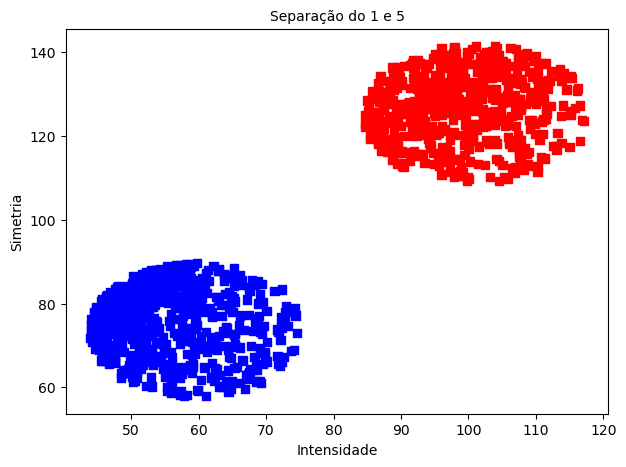

In [24]:
# Plotando

cores = ['blue' if i == 1 else 'red' for i in y_train_1_5]

plt.figure(figsize=(7, 5))
plt.scatter(X_train_1_5[:, 0], X_train_1_5[:, 1], color=cores, marker="s")
plt.xlabel('Intensidade',fontsize=10)
plt.ylabel('Simetria',fontsize=10)
plt.title("Separação do 1 e 5", fontsize=10)
plt.show()

In [25]:
# inserindo o bias
X_train_1_5_bias = np.insert(X_train_1_5, 0, 1, axis=1)
X_test_1_5_bias = np.insert(X_test_1_5, 0, 1, axis=1)

X_train_1_5_bias, y_train_1_5

(array([[  1.        ,  44.70196078,  69.27058824],
        [  1.        ,  59.85098039,  83.44313725],
        [  1.        ,  48.55294118,  79.04313725],
        ...,
        [  1.        , 110.7254902 , 133.01960784],
        [  1.        ,  99.30588235, 132.13333333],
        [  1.        , 101.17254902, 141.36470588]]),
 array([ 1,  1,  1, ..., -1, -1, -1]))

In [26]:
def exibirMatrizConfusao(y_test, y_pred):
    matriz = confusion_matrix(y_test, y_pred)

    print("---------- Matriz de Confusão ----------\n")
    print("\t\tNegativo\tPositivo\n----------------------------------------")
    print(f"Negativo\t{matriz[0][0]}\t\t{matriz[0][1]}")
    print(f"Positivo\t{matriz[1][0]}\t\t{matriz[1][1]}")

In [85]:
perceptron = PLA()

# treinando o modelo
%time perceptron.fit(X_train_1_5_bias, y_train_1_5)

# testando o modelo
y_pred = perceptron.predict(X_test_1_5_bias)

for i in range(5):
    print(f"Predição: {y_pred[i]} | Valor esperado: {y_test_1_5[i]}")

print("\n---------- Classificação do Perceptron ---------- ")

print(classification_report(y_test_1_5, y_pred))

w0_PLA = perceptron.get_w()

print(w0_PLA)

exibirMatrizConfusao(y_test_1_5, y_pred)

Número total de iterações realizadas:  16394
CPU times: total: 469 ms
Wall time: 495 ms
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1

---------- Classificação do Perceptron ---------- 
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

[ 4.30800000e+03 -5.23450980e+01 -1.41176471e-01]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	291		0
Positivo	0		292


### Regressão Linear

In [89]:
regressao_linear = RegressaoLinear()

# treinando o modelo
%time regressao_linear.fit(X_train_1_5_bias, y_train_1_5)

# testando o modelo
y_pred = regressao_linear.predict(X_test_1_5_bias)

for i in range(5):
    print(f"Predição: {y_pred[i]} | Valor esperado: {y_test_1_5[i]}")

print("\n---------- Classificação da Regressão Linear ---------- ")

print(classification_report(y_test_1_5, y_pred))

w0_LR = regressao_linear.get_w()

print(w0_LR)
exibirMatrizConfusao(y_test_1_5, y_pred)

CPU times: total: 0 ns
Wall time: 771 µs
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1

---------- Classificação da Regressão Linear ---------- 
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

[ 3.58751288 -0.01875499 -0.02111635]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	291		0
Positivo	0		292


In [90]:
acuracia1v5RL = accuracy_score(y_test_1_5, y_pred)
print(acuracia1v5RL)

1.0


### Regressão Logística 

In [91]:
regressao_logistica = RegressaoLogistica(tmax=50_000, bs=100_000)

# treinando o modelo
%time regressao_logistica.fit(X_train_1_5_bias, y_train_1_5)

# testando o modelo
y_pred = regressao_logistica.predict(X_test_1_5_bias)

for i in range(5):
    print(f"Predição: {y_pred[i]} | Valor esperado: {y_test_1_5[i]}")

print("\n---------- Classificação da Regressão Logística ---------- ")

print(classification_report(y_test_1_5, y_pred))

w0_logistica = regressao_logistica.get_w()
print(w0_logistica)
exibirMatrizConfusao(y_test_1_5, y_pred)

CPU times: total: 1.05 s
Wall time: 1.08 s
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1
Predição: 1.0 | Valor esperado: 1

---------- Classificação da Regressão Logística ---------- 
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

[38.34045253 -0.26054036 -0.18144034]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	291		0
Positivo	0		292


### Comparação dos três modelos

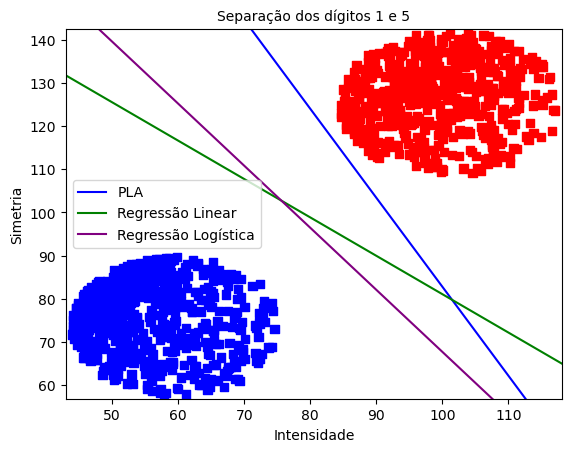

In [30]:
plt.axis([min(X_train_1_5[:,0]) - 1, max(X_train_1_5[:,0]) + 1, min(X_train_1_5[:,1]) - 1, max(X_train_1_5[:,1]) + 1])

cores = ['blue' if i == 1 else 'red' for i in y_train_1_5]
plt.scatter(X_train_1_5[:, 0], X_train_1_5[:, 1], color=cores, marker="s")

# domínio das funções
x = np.linspace(min(X_train_1_5[:,0]) - 1, max(X_train_1_5[:,0]) + 1, 100)

# plotando a reta de decisão do PLA
y = -(w0_PLA[1] * x + w0_PLA[0]) / w0_PLA[2]
plt.plot(x, y, color='blue', label='PLA')

# plotando a reta de decisão da Regressão Linear
y = -(w0_LR[1] * x + w0_LR[0]) / w0_LR[2]
plt.plot(x, y, color='green', label='Regressão Linear')

# plotando a reta de decisão da Regressão Logística
y = -(w0_logistica[1] * x + w0_logistica[0]) / w0_logistica[2]
plt.plot(x, y, color='purple', label='Regressão Logística')

plt.title("Separação dos dígitos 1 e 5", fontsize=10)
plt.xlabel('Intensidade', fontsize=10)
plt.ylabel('Simetria', fontsize=10)
plt.legend()
plt.show()

## Todos contra Todos

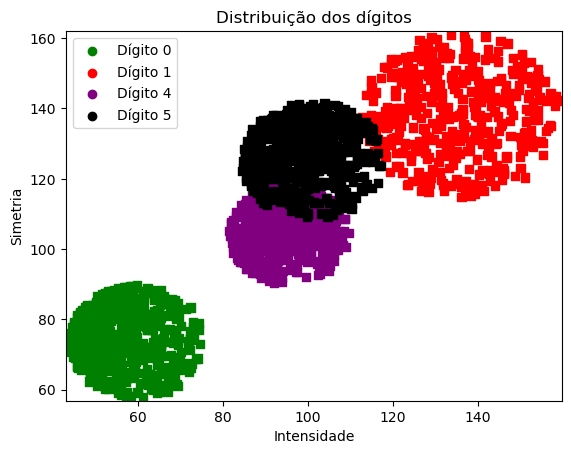

In [31]:
plt.axis([min(X_train[:,0]) - 1, max(X_train[:,0]) + 1, min(X_train[:,1]) - 1, max(X_train[:,1]) + 1])

cores = ['green' if i == 1 else 'red' if i == 0 else 'purple' if i == 4 else 'black' for i in y_train]

scatter = plt.scatter(X_train[:, 0], X_train[:, 1], color=cores, marker="s")

legend_labels = {
    'green': 'Dígito 0',
    'red': 'Dígito 1',
    'purple': 'Dígito 4',
    'black': 'Dígito 5'
}

for cor, label in legend_labels.items():
    plt.scatter([], [], c=cor, label=label)


plt.xlabel('Intensidade', fontsize=10)
plt.ylabel('Simetria', fontsize=10)
plt.legend()
plt.title("Distribuição dos dígitos")
plt.show()


In [93]:
# Começando pelo 1 porque ele é linearmente separável
# PLA

X_train_um = X_train.copy()
X_test_um = X_test.copy()

y_train_um = np.where(y_train == 1, +1, -1)
y_test_um = np.where(y_test == 1, +1, -1)

print("Amostras de treino: ", len(X_train_um), "\tRótulos de treino: ", len(y_train_um))
print("Amostras de teste: ", len(X_test_um), "\tRótulos de teste ", len(y_test_um))
X_train_um, y_train_um

#inserindo o bias
X_train_um_bias = np.insert(X_train_um, 0, 1, axis=1)
X_test_um_bias = np.insert(X_test_um, 0, 1, axis=1)

Amostras de treino:  2186 	Rótulos de treino:  2186
Amostras de teste:  1115 	Rótulos de teste  1115


In [94]:
perceptron = PLA(50_000)

# treinando o modelo
%time perceptron.fit(X_train_um_bias, y_train_um)

# testando o modelo
y_pred = perceptron.predict(X_test_um_bias)

print("\n---------- Classificação do Perceptron ----------\n")

print(classification_report(y_test_um, y_pred))

w1_PLA = perceptron.get_w()

print(w1_PLA)

print(exibirMatrizConfusao(y_test_um, y_pred))

Número total de iterações realizadas:  46107
CPU times: total: 1.86 s
Wall time: 1.9 s

---------- Classificação do Perceptron ----------

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       292

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115

[11635.          -166.38039216    12.14901961]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	823		0
Positivo	0		292
None


In [95]:
# Regressão Linear

regressao_linear = RegressaoLinear()

# treinando o modelo
%time regressao_linear.fit(X_train_um_bias, y_train_um)

# testando o modelo
y_pred = regressao_linear.predict(X_test_um_bias)

print("\n---------- Classificação da Regressão Linear ----------\n")

print(classification_report(y_test_um, y_pred))

w1_LR = regressao_linear.get_w()

print(w1_LR)

print(exibirMatrizConfusao(y_test_um, y_pred))

CPU times: total: 0 ns
Wall time: 0 ns

---------- Classificação da Regressão Linear ----------

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       292

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115

[ 2.6042966  -0.01193896 -0.01779691]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	823		0
Positivo	0		292
None


In [96]:
# Regressão Logística

regressao_logistica = RegressaoLogistica(tmax=100_000, bs=100_000)

# treinando o modelo
%time regressao_logistica.fit(X_train_um_bias, y_train_um)

# testando o modelo
y_pred = regressao_logistica.predict(X_test_um_bias)

print("\n---------- Classificação da Regressão Logística ----------\n")

w1_logistica = regressao_logistica.get_w()

print(classification_report(y_test_um, y_pred))

print(w1_logistica)

print(exibirMatrizConfusao(y_test_um, y_pred))

CPU times: total: 1.52 s
Wall time: 1.58 s

---------- Classificação da Regressão Logística ----------

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       292

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115

[26.99751588 -0.24066687 -0.09866787]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	823		0
Positivo	0		292
None


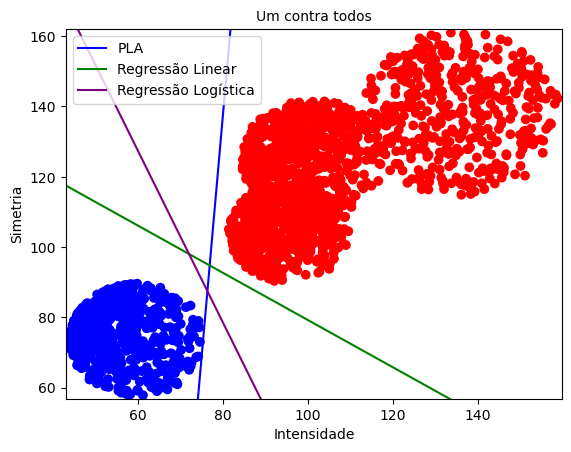

In [97]:
# limites dos eixos x e y
plt.axis([min(X_train_um[:,0]) - 1, max(X_train_um[:,0]) + 1, min(X_train_um[:,1]) - 1, max(X_train_um[:,1]) + 1])

# colorindo de azul os pontos do dígito 1 (com label 1) e de vermelho os pontos com label -1
cores = ['blue' if i == 1 else 'red' for i in y_train_um]

# plotando os pontos
plt.scatter(X_train_um[:, 0], X_train_um[:, 1], color=cores)

# domínio das funções
x = np.linspace(min(X_train_um[:,0]) - 1, max(X_train_um[:,0]) + 1, 100)

# plotando a reta de decisão do PLA
y = -(w1_PLA[1] * x + w1_PLA[0]) / w1_PLA[2]
plt.plot(x, y, color='blue', label='PLA')

# plotando a reta de decisão da Regressão Linear
y = -(w1_LR[1] * x + w1_LR[0]) / w1_LR[2]
plt.plot(x, y, color='green', label='Regressão Linear')

# plotando a reta de decisão da Regressão Logística
y = -(w1_logistica[1] * x + w1_logistica[0]) / w1_logistica[2]
plt.plot(x, y, color="purple", label='Regressão Logística')

plt.title("Um contra todos", fontsize=10)
plt.xlabel('Intensidade', fontsize=10)
plt.ylabel('Simetria', fontsize=10)
plt.legend()
plt.show()

In [98]:
## Zero contra todos

# Como já foi realizado o 1 contra todos, para realizar a do 0 contra todos precisa-se remover o label=1
X_train_zero = X_train.copy()
X_test_zero = X_test.copy()

# onde for diferente de 1
indices = np.where(y_train != 1)[0]

X_train_zero = X_train_zero[indices]
y_train_zero = y_train[indices]

indices = np.where(y_test != 1)[0]

X_test_zero = X_test_zero[indices]
y_test_zero = y_test[indices]
X_train_zero.shape, y_train_zero.shape, X_test_zero.shape, y_test_zero.shape

# todos os dígitos que são 0 recebem o valor alvo +1
y_train_zero = np.where(y_train_zero == 0, +1, -1)
y_test_zero = np.where(y_test_zero == 0, +1, -1)

print("Tamanho de X_train_zero", len(X_train_zero),"\tTamanho de y_train_zero", len(y_train_zero))
print("Tamanho de X_test_zero", len(X_test_zero),"\tTamanho de y_test_zero", len(y_test_zero))

#inserindo o bias
X_train_zero_bias = np.insert(X_train_zero, 0, 1, axis=1)
X_test_zero_bias = np.insert(X_test_zero, 0, 1, axis=1)


Tamanho de X_train_zero 1578 	Tamanho de y_train_zero 1578
Tamanho de X_test_zero 823 	Tamanho de y_test_zero 823


In [99]:
perceptron = PLA(maxIter=500_000)

# treinando o modelo
%time perceptron.fit(X_train_zero_bias, y_train_zero)

# testando o modelo
y_pred = perceptron.predict(X_test_zero_bias)

print("\n---------- Classificação do Perceptron ----------\n")
print(classification_report(y_test_zero, y_pred))

w0_PLA = perceptron.get_w()
print(w0_PLA)

Número total de iterações realizadas:  500000
CPU times: total: 17 s
Wall time: 17.3 s

---------- Classificação do Perceptron ----------

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98       605
           1       0.93      0.95      0.94       218

    accuracy                           0.97       823
   macro avg       0.96      0.96      0.96       823
weighted avg       0.97      0.97      0.97       823

[-58588.            679.15294118   -149.75686274]


In [43]:
exibirMatrizConfusao(y_test_zero, y_pred)

---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	586		19
Positivo	72		146


In [44]:
regressao_linear = RegressaoLinear()

# treinando o modelo
%time regressao_linear.fit(X_train_zero_bias, y_train_zero)

# testando o modelo
y_pred = regressao_linear.predict(X_test_zero_bias)

print("\n---------- Classificação da Regressão Linear ----------\n")

print(classification_report(y_test_zero, y_pred))

w0_LR = regressao_linear.get_w()
print(w0_LR)

print(exibirMatrizConfusao(y_test_zero, y_pred))

CPU times: total: 0 ns
Wall time: 2.03 ms

---------- Classificação da Regressão Linear ----------

              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       605
           1       1.00      0.95      0.97       218

    accuracy                           0.99       823
   macro avg       0.99      0.97      0.98       823
weighted avg       0.99      0.99      0.99       823

[-5.24863764  0.03802901  0.00592876]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	605		0
Positivo	11		207
None


In [45]:
regressao_logistica = RegressaoLogistica(tmax=500_000, bs=100_000)

# treinando o modelo
%time regressao_logistica.fit(X_train_zero_bias, y_train_zero)

# testando o modelo
y_pred = regressao_logistica.predict(X_test_zero_bias)

print("\n---------- Classificação da Regressão Logística ----------\n")
print(classification_report(y_test_zero, y_pred))

w0_logistica = regressao_logistica.get_w()
print(w0_logistica)

print(exibirMatrizConfusao(y_test_zero, y_pred))

CPU times: total: 13.3 s
Wall time: 13.5 s

---------- Classificação da Regressão Logística ----------

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       605
           1       1.00      1.00      1.00       218

    accuracy                           1.00       823
   macro avg       1.00      1.00      1.00       823
weighted avg       1.00      1.00      1.00       823

[-144.41678131    0.92793593    0.28440167]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	604		1
Positivo	1		217
None


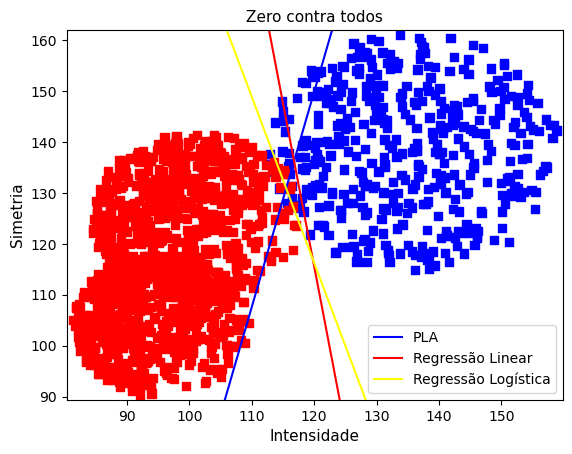

In [48]:

plt.axis([min(X_train_zero[:,0]) - 1, max(X_train_zero[:,0]) + 1, min(X_train_zero[:,1]) - 1, max(X_train_zero[:,1]) + 1]) 

# colorindo de azul os pontos do digíto 0 (com label 1) e de vermelho os pontos com label -1
cores = ['blue' if i == 1 else 'red' for i in y_train_zero]

# plotando os pontos
plt.scatter(X_train_zero[:, 0], X_train_zero[:, 1], color=cores, marker="s")

# domínio das funções
x = np.linspace(min(X_train_zero[:,0]) - 1, max(X_train_zero[:,0]) + 1, 100)

# plotando a reta de decisão do PLA
y = -(w0_PLA[1] * x + w0_PLA[0]) / w0_PLA[2]
plt.plot(x, y, color='blue', label='PLA')

# plotando a reta de decisão da Regressão Linear
y = -(w0_LR[1] * x + w0_LR[0]) / w0_LR[2]
plt.plot(x, y, color='red', label='Regressão Linear')

# plotando a reta de decisão da Regressão Logística
y = -(w0_logistica[1] * x + w0_logistica[0]) / w0_logistica[2]
plt.plot(x, y, color='yellow', label='Regressão Logística')

plt.title("Zero contra todos", fontsize=11)
plt.xlabel('Intensidade', fontsize=11)
plt.ylabel('Simetria', fontsize=11)
plt.legend()
plt.show()

### Quatro contra todos

In [49]:
# para o quatro contra todos, removemos os dados com os rótulos 0 e 1

X_train_quatro = X_train.copy()
X_test_quatro = X_test.copy()

indices = np.where((y_train !=0) & (y_train !=1))[0]
print(indices)

X_train_quatro = X_train_quatro[indices]
y_train_quatro = y_train[indices]

indices = np.where(( (y_test !=0) & (y_test !=1) ))

X_test_quatro = X_test_quatro[indices]
y_test_quatro = y_test[indices]


X_train_quatro.shape, y_train_quatro.shape, X_test_quatro.shape, y_test_quatro.shape

[1033 1034 1035 ... 2183 2184 2185]


((1153, 2), (1153,), (605, 2), (605,))

In [50]:
# classificação
y_train_quatro = np.where(y_train_quatro == 4, +1, -1)
y_test_quatro = np.where(y_test_quatro == 4, +1, -1)


print("Tamanho de X_train_quatro: ", len(X_train_quatro),"\tTamanho de y_train_quatro: ", len(y_train_quatro))
print("Tamanho de X_test_quatro: ", len(X_test_quatro),"\tTamanho de y_test_quatro: ", len(y_test_quatro))

y_train_quatro, y_test_quatro

Tamanho de X_train_quatro:  1153 	Tamanho de y_train_quatro:  1153
Tamanho de X_test_quatro:  605 	Tamanho de y_test_quatro:  605


(array([ 1,  1,  1, ..., -1, -1, -1]),
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  

In [51]:
#inserindo o bias
X_train_quatro_bias = np.insert(X_train_quatro, 0, 1, axis=1)
X_test_quatro_bias = np.insert(X_test_quatro, 0, 1, axis=1)

In [55]:
perceptron = PLA(maxIter=1_000_000)

# treinando o modelo
%time perceptron.fit(X_train_quatro_bias, y_train_quatro)

# testando o modelo
y_pred = perceptron.predict(X_test_quatro_bias)

print("\n---------- Classificação do Perceptron ----------\n")
print(classification_report(y_test_quatro, y_pred))

w4_PLA = perceptron.get_w()
print(w4_PLA)
exibirMatrizConfusao(y_test_quatro, y_pred)

Número total de iterações realizadas:  1000000
CPU times: total: 30 s
Wall time: 30.4 s

---------- Classificação do Perceptron ----------

              precision    recall  f1-score   support

          -1       0.91      0.85      0.88       291
           1       0.87      0.92      0.90       314

    accuracy                           0.89       605
   macro avg       0.89      0.89      0.89       605
weighted avg       0.89      0.89      0.89       605

[56747.           452.32156863  -861.76470588]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	248		43
Positivo	24		290


In [57]:
regressao_linear = RegressaoLinear()

%time regressao_linear.fit(X_train_quatro_bias, y_train_quatro)

y_pred = regressao_linear.predict(X_test_quatro_bias)

print("\n---------- Classificação da Regressão Linear ----------\n")

print(classification_report(y_test_quatro, y_pred))

w4_LR = regressao_linear.get_w()
print(w4_LR)

exibirMatrizConfusao(y_test_quatro, y_pred)

CPU times: total: 0 ns
Wall time: 0 ns

---------- Classificação da Regressão Linear ----------

              precision    recall  f1-score   support

          -1       0.97      0.92      0.94       291
           1       0.93      0.97      0.95       314

    accuracy                           0.95       605
   macro avg       0.95      0.95      0.95       605
weighted avg       0.95      0.95      0.95       605

[ 7.74261671e+00 -5.11403372e-03 -6.24322897e-02]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	267		24
Positivo	8		306


In [59]:
regressao_logistica = RegressaoLogistica(tmax=1_000_000, bs=64, eta=0.01)

%time regressao_logistica.fit(X_train_quatro_bias, y_train_quatro)

y_pred = regressao_logistica.predict(X_test_quatro_bias)

print("\n---------- Classificação da Regressão Logística ----------\n")

print(classification_report(y_test_quatro, y_pred))

w4_logistica = regressao_logistica.get_w()
print(w4_logistica)
print(exibirMatrizConfusao(y_test_quatro, y_pred))

CPU times: total: 56 s
Wall time: 59.2 s

---------- Classificação da Regressão Logística ----------

              precision    recall  f1-score   support

          -1       0.84      0.80      0.82       291
           1       0.82      0.86      0.84       314

    accuracy                           0.83       605
   macro avg       0.83      0.83      0.83       605
weighted avg       0.83      0.83      0.83       605

[ 5.77593645  0.13117526 -0.15832517]
---------- Matriz de Confusão ----------

		Negativo	Positivo
----------------------------------------
Negativo	232		59
Positivo	44		270
None


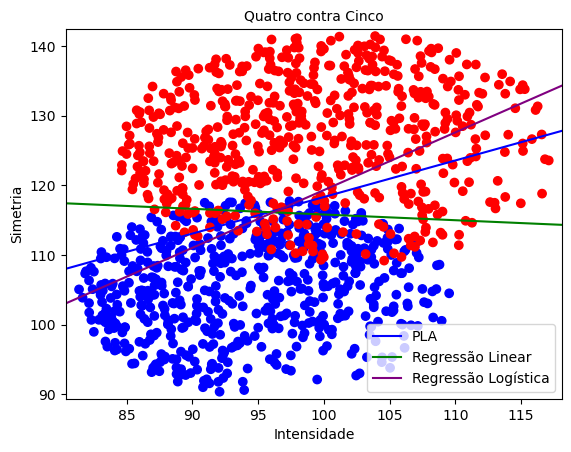

In [60]:
# limites dos eixos x e y
plt.axis([min(X_train_quatro[:,0]) - 1, max(X_train_quatro[:,0]) + 1, min(X_train_quatro[:,1]) - 1, max(X_train_quatro[:,1]) + 1]) #set the size of the x and y axes

# colorindo de azul os pontos do digíto 4 (com label 1) e de vermelho os pontos com label -1
cores = ['blue' if i == 1 else 'red' for i in y_train_quatro]

# plotando os pontos
plt.scatter(X_train_quatro[:, 0], X_train_quatro[:, 1], color=cores)

# domínio das funções
x = np.linspace(min(X_train_quatro[:,0]) - 1, max(X_train_quatro[:,0]) + 1, 100)

# plotando a reta de decisão do PLA
y = -(w4_PLA[1] * x + w4_PLA[0]) / w4_PLA[2]
plt.plot(x, y, color='blue', label='PLA')

# plotando a reta de decisão da Regressão Linear
y = -(w4_LR[1] * x + w4_LR[0]) / w4_LR[2]
plt.plot(x, y, color='green', label='Regressão Linear')

# plotando a reta de decisão da Regressão Logística
y = -(w4_logistica[1] * x + w4_logistica[0]) / w4_logistica[2]
plt.plot(x, y, color='purple', label='Regressão Logística')

plt.title("Quatro contra Cinco", fontsize=10)
plt.xlabel('Intensidade', fontsize=10)
plt.ylabel('Simetria', fontsize=10)
plt.legend()
plt.show()

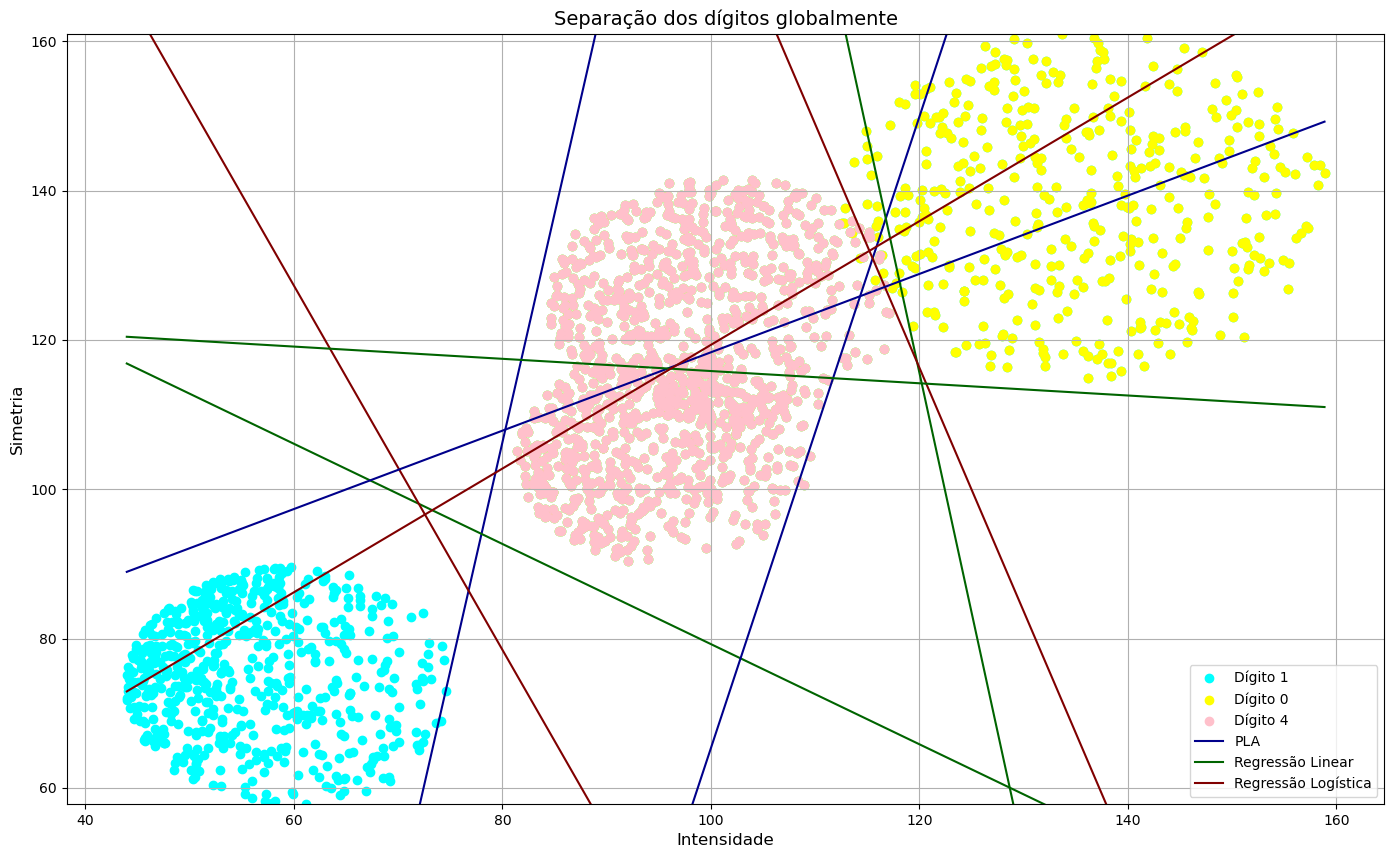

In [79]:
# Criando uma figura e eixo para o plot combinado
plt.figure(figsize=(17, 10))

# Plotando os pontos de cada dígito
plt.scatter(X_train_um[:, 0], X_train_um[:, 1], color='cyan',label='Dígito 1')
plt.scatter(X_train_zero[:, 0], X_train_zero[:, 1], color='yellow', label='Dígito 0')
plt.scatter(X_train_quatro[:, 0], X_train_quatro[:, 1], color='pink',label='Dígito 4')

# Domínio das funções
x = np.linspace(min(np.min(X_train_1_5[:, 0]), np.min(X_train_um[:, 0]), np.min(X_train_zero[:, 0]), np.min(X_train_quatro[:, 0])),
                max(np.max(X_train_1_5[:, 0]), np.max(X_train_um[:, 0]), np.max(X_train_zero[:, 0]), np.max(X_train_quatro[:, 0])), 100)


# Reta de separação para o dígito 1
y = -(w1_PLA[1] * x + w1_PLA[0]) / w1_PLA[2]
plt.plot(x, y, color='darkblue', label='PLA')
y = -(w1_LR[1] * x + w1_LR[0]) / w1_LR[2]
plt.plot(x, y, color='darkgreen', label='Regressão Linear')
y = -(w1_logistica[1] * x + w1_logistica[0]) / w1_logistica[2]
plt.plot(x, y, color='maroon', label='Regressão Logística')

# Reta de separação para o dígito 0
y = -(w0_PLA[1] * x + w0_PLA[0]) / w0_PLA[2]
plt.plot(x, y, color='darkblue')
y = -(w0_LR[1] * x + w0_LR[0]) / w0_LR[2]
plt.plot(x, y, color='darkgreen')
y = -(w0_logistica[1] * x + w0_logistica[0]) / w0_logistica[2]
plt.plot(x, y, color='maroon')

# Reta de separação para o dígito 4
y = -(w4_PLA[1] * x + w4_PLA[0]) / w4_PLA[2]
plt.plot(x, y, color='darkblue')
y = -(w4_LR[1] * x + w4_LR[0]) / w4_LR[2]
plt.plot(x, y, color='darkgreen')
y = -(w4_logistica[1] * x + w4_logistica[0]) / w4_logistica[2]
plt.plot(x, y, color='maroon')

plt.title("Separação dos dígitos globalmente", fontsize=14)
plt.xlabel('Intensidade', fontsize=12)
plt.ylabel('Simetria', fontsize=12)

plt.ylim(min(np.min(X_train_1_5[:, 1]), np.min(X_train_um[:, 1]), np.min(X_train_zero[:, 1]), np.min(X_train_quatro[:, 1])),
         max(np.max(X_train_1_5[:, 1]), np.max(X_train_um[:, 1]), np.max(X_train_zero[:, 1]), np.max(X_train_quatro[:, 1])))

plt.legend()
plt.grid(True)
plt.show()


### Testando com imagens

In [164]:
from PIL import Image

def conversor_imagem(path):
    # exibe a imagem
    img = Image.open(path)
    plt.imshow(img)

    # converte a imagem num array
    img = np.array(img)
    # redimensiona a imagem de 28x28 para 1x784
    img = img.reshape(1, 784)
    print(img.shape)

    #calcula a intensidade e a simetria
    intensidade_img = intensidade(img)
    SV = simetria_vertical(img)
    SH = simetria_horizontal(img)

    return [intensidade_img, SV + SH]

In [165]:
#classifica usando o sinal para ordenar e iterando sobre cada peso
def classificador(x, pesos):
    #classifica x como 0,1,4 ou 5
    #x é um array com intensidade e simetria
    #coloca o bias no x

    x = [1,x[0],x[1]]

    digitos = [0,1,4]
    for i in digitos:
        indice = i

        if indice == 4:
            indice = 2

        #usa a função de ativação sign para ordenar
        if np.sign(np.dot(pesos[indice], x)) == 1:
            return i

        else:
            if i == 4:
                return 5

(1, 784)
[145.43529411764706, 116.69803921568628]
A imagem é:  0


C:\Users\vinic\AppData\Local\Temp\ipykernel_11704\2412444279.py:8: RuntimeWarning: overflow encountered in scalar subtract
  diferenca = np.abs(digito[i][j] - digito[i][27-j])
C:\Users\vinic\AppData\Local\Temp\ipykernel_11704\2412444279.py:21: RuntimeWarning: overflow encountered in scalar subtract
  diferenca = np.abs(digito[j][i] - digito[27-j][i])


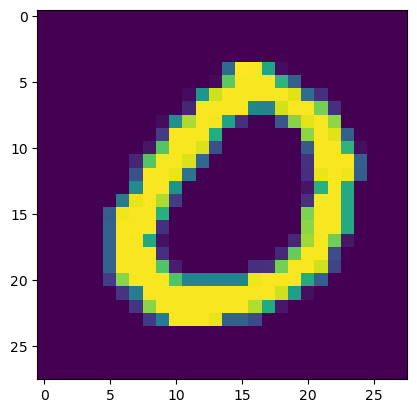

In [167]:
x = conversor_imagem('/imagens/0.png')
print(x)
resultado = classificador(x,[w0_PLA, w1_logistica, w4_LR])
print("A imagem é: ", resultado)

(1, 784)
[58.1764705882353, 51.79607843137255]
A imagem é:  1


C:\Users\vinic\AppData\Local\Temp\ipykernel_11704\2412444279.py:8: RuntimeWarning: overflow encountered in scalar subtract
  diferenca = np.abs(digito[i][j] - digito[i][27-j])
C:\Users\vinic\AppData\Local\Temp\ipykernel_11704\2412444279.py:21: RuntimeWarning: overflow encountered in scalar subtract
  diferenca = np.abs(digito[j][i] - digito[27-j][i])


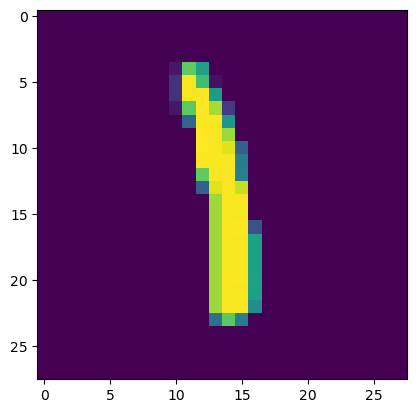

In [168]:
x = conversor_imagem('/imagens/1.png')
print(x)
resultado = classificador(x,[w0_PLA, w1_logistica, w4_LR])
print("A imagem é: ", resultado)

(1, 784)
[101.17254901960784, 124.8]
A imagem é:  5


C:\Users\vinic\AppData\Local\Temp\ipykernel_11704\2412444279.py:8: RuntimeWarning: overflow encountered in scalar subtract
  diferenca = np.abs(digito[i][j] - digito[i][27-j])
C:\Users\vinic\AppData\Local\Temp\ipykernel_11704\2412444279.py:21: RuntimeWarning: overflow encountered in scalar subtract
  diferenca = np.abs(digito[j][i] - digito[27-j][i])


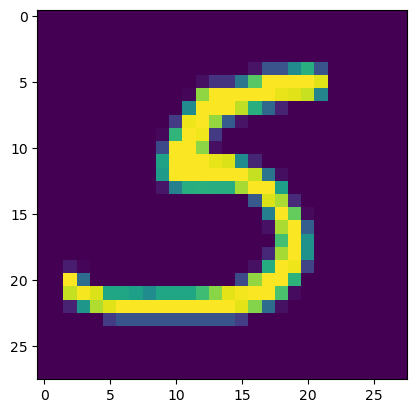

In [170]:
x = conversor_imagem('/imagens/5.png')
print(x)
resultado = classificador(x,[w0_PLA, w1_logistica, w4_LR])
print("A imagem é: ", resultado)

(1, 784)
[92.45490196078431, 93.31764705882352]
A imagem é:  4


C:\Users\vinic\AppData\Local\Temp\ipykernel_11704\2412444279.py:8: RuntimeWarning: overflow encountered in scalar subtract
  diferenca = np.abs(digito[i][j] - digito[i][27-j])
C:\Users\vinic\AppData\Local\Temp\ipykernel_11704\2412444279.py:21: RuntimeWarning: overflow encountered in scalar subtract
  diferenca = np.abs(digito[j][i] - digito[27-j][i])


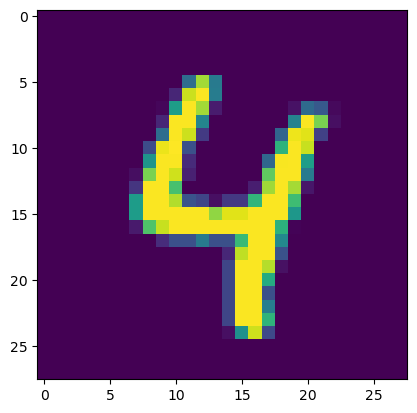

In [173]:
x = conversor_imagem('/imagens/4.png')
print(x)
resultado = classificador(x,[w0_PLA, w1_logistica, w4_LR])
print("A imagem é: ", resultado)